# Compute spectral ratio of the nearest sensor with the source.

This notebook performs the spectral ratio analysis to investigate the measurement resolution of GP events.

2024.10.31 Kurama Okubo

- 2024.11.18 update processing parameters. Clean up the figures.
- 2025.03.24 update for master plot. Apply a two-way high-pass filter and process 33 GP events from the original 44 after thresholding out events that do not fit the STF. We follow Lengliné et al. (2014) Fig. 8 to show the difference in corner frequency between the small and large events.
- 2025.03.25 update for stacked spectra.
- 2025.03.26 update for spectral ratio fitting.

We acknowledge the use of OpenAI’s ChatGPT for assistance in Python programming and optimization techniques.

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.ticker as mticker
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from obspy.core.utcdatetime import UTCDateTime    
from tqdm import tqdm
import warnings
import time
import pickle 
import seaborn as sns

from scipy.optimize import minimize

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = False

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = False

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


In [2]:
figdir = "../figure/"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [3]:
# channel table
channel_finame = '../../AEchanneltable/AEsensorlocation_onFB03_table.csv'

# datadir
data_inputdir = '../../../SourceInvFit/data/04_AE_obs_isocoord'

In [4]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())
# channel_loc

# Load source parameters

In [5]:
# read event catalog
Nvalidsensors_thresh = 4
df_events = pd.read_csv("../../../GougeEventCatalog/data/gougeeventcatalog__fb03-087__G3__Q50.csv", index_col=0)
df_selected = df_events[df_events["Nvalidsensors"] >= Nvalidsensors_thresh]
print(len(df_selected))
df_selected.head()

33


,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std
event_id,,,,,,,,,,,
4,1.75,42.474772,3,A,50,4,0.592607,0.178671,-6.218156,0.000003,1.530315e-07
9,1.75,47.662693,5,F,50,4,0.046991,0.007419,-6.951990,0.000002,3.643121e-07
18,1.75,56.727044,8,F,50,4,0.755830,0.192507,-6.147717,0.000003,3.100882e-07
19,1.75,59.103175,9,F,50,4,0.055755,0.016951,-6.902476,0.000002,2.699155e-07
20,1.75,59.103526,9,F,50,4,0.865466,0.210250,-6.108500,0.000003,1.352659e-07


In [6]:
eventid_sorted = df_selected.sort_values(by="M0", ascending=False).index

In [7]:
datacases_sorted = [f"fb03-087__{x:04d}" for x in eventid_sorted]

In [8]:
len(datacases_sorted)

33

In [9]:
# datacases_sorted

In [10]:
# load color dictionary consistent to the plot of the repeated waveforms
repeated_sensor_lcdict = "OL23" # the color dict is same for all the sensor although separately saved.
gougepatch_id = "G3"
with open(f'../../../ComputeScaling/data/01_plot_gougeevents/lc_dict_{gougepatch_id}_{repeated_sensor_lcdict}.pkl', 'rb') as fi:
    lc_dict = pickle.load(fi)

# Process flow

We compute the mean and std of the stacked spectra of the raw P waveforms before instrumental response removal.

1. Select events to compute the spectral ratio
2. Trim the P waveform and compute the spectra
3. Save the data to dictionary
4. Plot the waveforms and spectra

We compute the spectral ratio as the fraction of the largest event divided by each event:

$$ \text{spectral ratio} = \dfrac{F^{\text{largest}}}{F^{\text{event}}}$$

# Read meta data

In [11]:
AEsensor_list = ["OL23", "OL07", "OL08", "OL22"]

## Load onset timing

In [12]:
dfs = []  # List to store DataFrames

for stnm in AEsensor_list:
    df_onset = pd.read_csv(f"../../../ComputeScaling/data/01_plot_gougeevents/P_repicked_onset_time_G3_{stnm}.csv", index_col=0)
    df_onset["datacase"] = df_onset.index
    dfs.append(df_onset)  # Append to the list

# Merge all DataFrames by stacking them
df_onset_merged = pd.concat(dfs, ignore_index=True)  # `ignore_index=True` resets the index

print(df_onset_merged.head())  # Check the merged DataFrame

   onset_npt sensor  onset_t[ms]  onset_d_ref[mm]        datacase
0        261   OL23       0.0161            99.82  fb03-087__0088
1        265   OL23       0.0165           102.30  fb03-087__0129
2        267   OL23       0.0167           103.54  fb03-087__0031
3        262   OL23       0.0162           100.44  fb03-087__0095
4        262   OL23       0.0162           100.44  fb03-087__0020


## Band-pass filter

In [13]:
# Parameters for filtering
# We use the same filter as the previously analyzed gouge events
freqmin = 0.08e6 #0.06e6 # 0.06e6 # 0.1e6
# freqmax = 1e6
butterworth_order = 4

# Select events

In [14]:
largest_event_id = 129
smallest_event_id = 126
target_event_ids = [24, 50, 52, 72]

largest_event_datacase = f"fb03-087__{largest_event_id:04d}"
smallest_event_datacase = f"fb03-087__{smallest_event_id:04d}"
target_event_datacase = [f"fb03-087__{x:04d}" for x in target_event_ids]


# Compute spectra

In [15]:
event_all = np.hstack([largest_event_datacase, smallest_event_datacase, target_event_datacase])

In [16]:
# P window length
pwin_pre = 1e-6 #3e-6 
pwin_len = 6e-6 #6e-6 #6e-6 

# Loading the raw data to get sampling_rate
tr = read(data_inputdir+f"/obs_isocoord_{AEsensor_list[0]}__{event_all[0]}.pickle", format="PICKLE")[0] # This is the raw waveform before the instrumental response removal
fs = tr.stats.sampling_rate

In [17]:
b_filt, a_filt = signal.butter(butterworth_order, freqmin, 'highpass', fs=fs, output='ba')
print(f"Apply {freqmin/1e3:.1f} kHz High-pass filter.")

Apply 80.0 kHz High-pass filter.


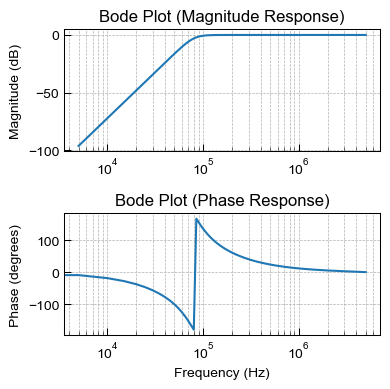

In [18]:
# Compute frequency response (for digital filter, use freqz)
w, h = signal.freqz(b_filt, a_filt, worN=1000, fs=fs)

# Create subplots for Bode plot
fig, axs = plt.subplots(2, 1, figsize=(4, 4))

# Magnitude plot
axs[0].semilogx(w[1:], 20 * np.log10(abs(h[1:])))  # Convert to dB
axs[0].set_title("Bode Plot (Magnitude Response)")
axs[0].set_ylabel("Magnitude (dB)")
axs[0].grid(which="both", linestyle="--", linewidth=0.5)

# Phase plot
axs[1].semilogx(w, np.angle(h, deg=True))
axs[1].set_title("Bode Plot (Phase Response)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Phase (degrees)")
axs[1].grid(which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

In [19]:
st_all = Stream()

for datacase in event_all:
    # datacase = event_all[0]
    
    for stnm in AEsensor_list:
        # stnm = AEsensor_list[3]
    
        # Loading the raw data
        tr_obs_raw = read(data_inputdir+f"/obs_isocoord_{stnm}__{datacase}.pickle", format="PICKLE")[0] # This is the raw waveform before the instrumental response removal
        tr_obs_raw.stats.location = f"{datacase}_raw"
        
        # Make filtered data for plotting the entire trace
        tr_obs_filtered = tr_obs_raw.copy().taper(0.05)
        tr_obs_filtered.data = signal.filtfilt(b_filt, a_filt, tr_obs_filtered.data, method='gust') # two-way filter 
        tr_obs_filtered.stats.location = f"{datacase}_filtered"
        
        # Trim the P wave window
        onset_t = df_onset_merged[(df_onset_merged["datacase"]==datacase) & (df_onset_merged["sensor"]==stnm)]["onset_t[ms]"].values[0]
        onset_p_ind = df_onset_merged[(df_onset_merged["datacase"]==datacase) & (df_onset_merged["sensor"]==stnm)]["onset_npt"].values[0]
        pwin_pre_k = int(pwin_pre*fs)
        pwin_len_k = int(pwin_len*fs)
        
        tr_obs_raw_trimmed = tr_obs_raw.copy()
        tr_obs_raw_trimmed.data = tr_obs_raw.data[onset_p_ind-pwin_pre_k:onset_p_ind+pwin_len_k]
        tr_obs_raw_trimmed.stats.location = f"{datacase}_raw_P"
        
        tr_obs_filtered_trimmed = tr_obs_filtered.copy()
        tr_obs_filtered_trimmed.data = tr_obs_filtered.data[onset_p_ind-pwin_pre_k:onset_p_ind+pwin_len_k]
        tr_obs_filtered_trimmed.stats.location = f"{datacase}_filtered_P"
        
        pt = tr_obs_raw.stats.pretrigger*1e-3 #[s]
        
        # store the trimmed timing
        tr_obs_raw_trimmed.stats.trim_st = pt+onset_t*1e-3 - pwin_pre #pt+pp-pwin_pre
        tr_obs_filtered_trimmed.stats.trim_st = pt+onset_t*1e-3 - pwin_pre #pt+pp-pwin_pre
        
        
        st_all.extend([tr_obs_raw, tr_obs_filtered, tr_obs_raw_trimmed, tr_obs_filtered_trimmed])

In [20]:
st_all

96 Trace(s) in Stream:

FB.OL23.fb03-087__0129_raw.Z | 2023-05-29T00:04:05.07096500Z - 2023-05-29T00:04:05.07127500Z | 10000000.0 Hz, 3101 samples
...
(94 other traces)
...
FB.OL22.fb03-087__0072_filtered_P.Z | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73445590Z | 10000000.0 Hz, 70 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

# Check the trimming

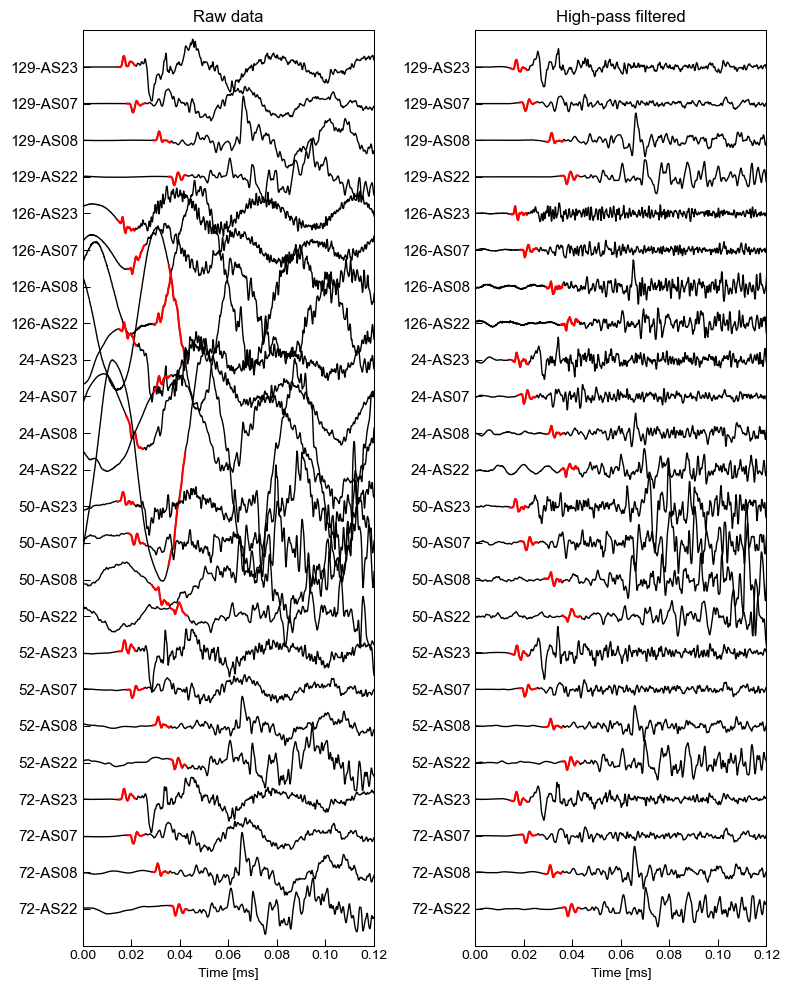

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(8, 10))

raw_ampnorm = 1e1
yshift = 0

pretrigger = st_all[0].stats.pretrigger

# for datacase in event_all:

ampnorm_normalized = 5

cp = 6200
# cs = 3600

ytickloc = []
yticklabel = []

for datacase in event_all:
    # datacase = event_all[0]

    gougeevent_id = int(datacase.split("__")[1])
    
    for stnm in AEsensor_list:
    
        tr_obs_raw = st_all.select(station=stnm, location=f"{datacase}_raw")[0]
        tr_obs_raw_trimmed = st_all.select(station=stnm,location=f"{datacase}_raw_P")[0]
    
        tr_obs_filtered = st_all.select(station=stnm, location=f"{datacase}_filtered")[0]
        tr_obs_filtered_trimmed = st_all.select(station=stnm, location=f"{datacase}_filtered_P")[0]
    
        tvec = tr_obs_raw.times()*1e3
        tvec_trimmed = tr_obs_raw_trimmed.times()
        trim_st = tr_obs_raw_trimmed.stats.trim_st

        ampnorm_peak_P = np.max(np.abs(tr_obs_filtered_trimmed.data))
        plotamp = abs(ampnorm_peak_P) * ampnorm_normalized

    
        # align at arrival time
        onset_p_t = df_onset_merged[(df_onset_merged["datacase"]==datacase) & (df_onset_merged["sensor"]==stnm)]["onset_t[ms]"].values[0]
        tp = tr_obs_raw.stats.dist / cp
        dtshift = tp - onset_p_t
    
        ax = axs[0]
        ax.plot(tvec - pretrigger + dtshift, tr_obs_raw.data/plotamp - yshift, "k-", lw=1.0)    
        ax.plot((tvec_trimmed + trim_st) * 1e3 - pretrigger + dtshift, tr_obs_raw_trimmed.data/plotamp - yshift, "r-", label="Raw", lw=1.5)
        
        ytickloc.append(-yshift)
        yticklabel.append(f"{gougeevent_id:d}-AS{stnm[2:]}")

        
        ax = axs[1]
        ax.plot(tvec - pretrigger + dtshift, tr_obs_filtered.data/plotamp - yshift, "k-", lw=1.0)
        ax.plot((tvec_trimmed + trim_st) * 1e3 - pretrigger + dtshift, tr_obs_filtered_trimmed.data/plotamp - yshift, "r-", label="Raw", lw=1.5)
    
    
        yshift += 1


for ax in axs:
    ax.set_xlim([0, 0.12])
    
    # ax.set_xlim([0, 0.12])
    ax.set_ylim([ytickloc[-1] - 1, ytickloc[0] + 1])
    ax.set_xlabel("Time [ms]")
    ax.set_yticks(np.round(ytickloc, 3))
    ax.set_yticklabels(yticklabel, fontsize=11)
    ax.set_xlabel("Time [ms]")


axs[0].set_title("Raw data")
axs[1].set_title("High-pass filtered")
fig.tight_layout()

plt.savefig(figdir + f"/debug_Pwavewindow.png", dpi=70)
plt.savefig(figdir + f"/debug_Pwavewindow.eps")


# Compute the spectra

We use the high-passed filter to avoid the artifact due to the detrend and demean on the long-period noise.

The spectral ratios are stacked.

In [22]:
# Compute amplitude spectra
def compute_sourcespectrum_amplitudespectrum(tr, dt, N=2**10):
    """
    tr: trace with source time function
    amplitude spectrum of moment rate function propotional to the far-field displacement
    """
    F = np.fft.rfft(tr, n=N) # * dt skip normalizing spectra with dt as this is not displacement spectra to evaluate M0
    freq = np.fft.rfftfreq(N, dt)
    Xabs = np.abs(F)

    return F, Xabs, freq

def compute_sourcespectrum(freq, M0, n, fc,):
    return M0 / (1 + (freq/fc)**n)

In [23]:
Freqdata_all = dict()

Nfft = 2**8 #2**7
print(Nfft, tr_obs_filtered_trimmed.stats.npts)

Istapering = True #True
tukey_alpha = 0.2 #1.0

for datacase in event_all:
    # datacase = event_all[0]

    gougeevent_id = int(datacase.split("__")[1])
    
    for stnm in AEsensor_list:
    
        tr_obs_raw = st_all.select(station=stnm, location=f"{datacase}_raw")[0]
        tr_obs_raw_trimmed = st_all.select(station=stnm,location=f"{datacase}_raw_P")[0]
    
        tr_obs_filtered = st_all.select(station=stnm, location=f"{datacase}_filtered")[0]
        tr_obs_filtered_trimmed = st_all.select(station=stnm, location=f"{datacase}_filtered_P")[0]
    
        # compute amplitude spectrum
        tr_obs_filtered_trimmed_detrended = tr_obs_filtered_trimmed.copy().detrend("constant").detrend("linear") # demean, detrend
        # tr_obs_filtered_trimmed_detrended = tr_obs_raw_trimmed.copy().detrend("constant").detrend("linear") # demean, detrend
        window = signal.windows.tukey(tr_obs_filtered_trimmed_detrended.stats.npts, alpha=tukey_alpha)
        assert tr_obs_filtered_trimmed_detrended.stats.npts < Nfft
        
        if Istapering:
            tr_obs_filtered_trimmed_detrended.data *= window
        
        F, Xabs, freq = compute_sourcespectrum_amplitudespectrum(tr_obs_filtered_trimmed_detrended.data, tr_obs_filtered_trimmed_detrended.stats.delta, N=Nfft)
    #     assert((np.abs(Xabs - Xabs2[:int(Nfft/2+1)])<1e9).all()) # Check if the one-sided power spectrum is computed
        key_F = f"F_{datacase}_{stnm}"
        key_Fabs = f"Fabs_{datacase}_{stnm}"
        key_freq = f"Ffreq_{datacase}_{stnm}"
    
        Freqdata_all[key_F] = F
        Freqdata_all[key_Fabs] = Xabs
        Freqdata_all[key_freq] = freq
    

256 70


# Compute the stacked spectral ratio

In [24]:
spectralratio_stacked = dict()

for datacase in event_all:
    # datacase = event_all[0]
    
    gougeevent_id = int(datacase.split("__")[1])
    freq = Freqdata_all[f"Ffreq_{datacase}_{AEsensor_list[0]}"]

    # compute the spectral ratio as Flarge/Fevent for each sensor
    spectralratio_station = np.zeros((len(AEsensor_list), len(freq)))
    for i, stnm in enumerate(AEsensor_list):
        Xabs_ref = Freqdata_all[f"Fabs_{largest_event_datacase}_{stnm}"]
        spectralratio_station[i, :] = Xabs_ref/Freqdata_all[f"Fabs_{datacase}_{stnm}"]
    
    key_freq = f"Ffreq_{datacase}"
    key_Fstacked = f"Fstacked_{datacase}"
    key_Fstacked_std = f"Fstacked_std_{datacase}"
    
    spectralratio_stacked[key_freq] = freq
    spectralratio_stacked[key_Fstacked] = np.mean(spectralratio_station, axis=0)
    spectralratio_stacked[key_Fstacked_std] = np.std(spectralratio_station, axis=0)


## Check the stacked spectra

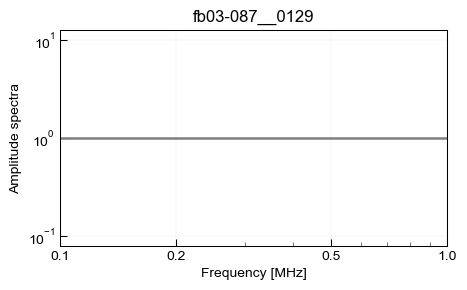

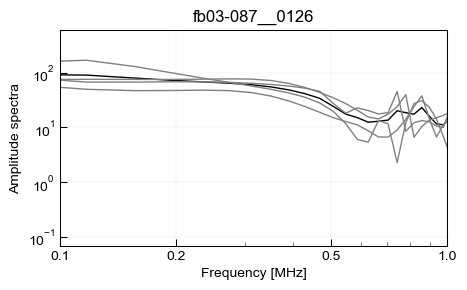

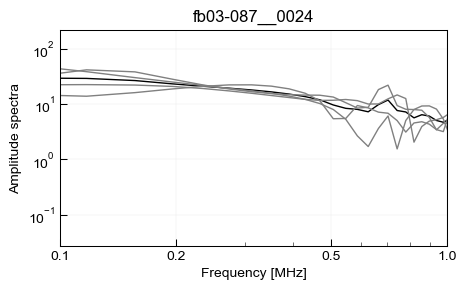

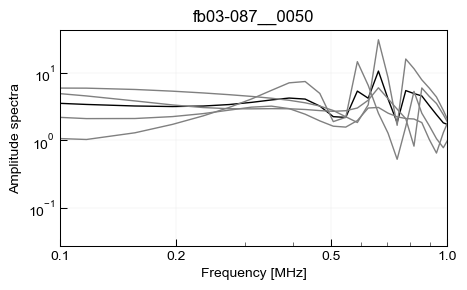

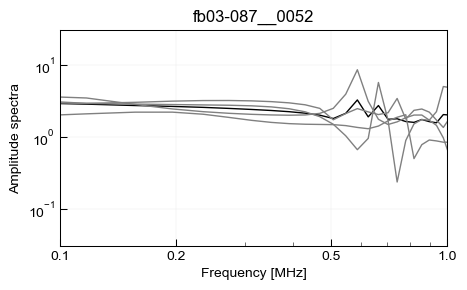

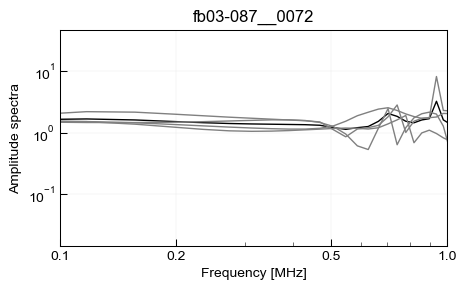

In [25]:
for datacase in event_all:

    fig, ax = plt.subplots(1, 1, figsize=(5, 2.8))

    
    key_freq = f"Ffreq_{datacase}"
    key_Fstacked = f"Fstacked_{datacase}"

    freq = spectralratio_stacked[key_freq]
    specratio_stacked = spectralratio_stacked[key_Fstacked]

    ax.loglog(freq/1e6, specratio_stacked, "k-", lw=1)

    # plot each sensor
    for stnm in AEsensor_list:
        Xabs_ref = Freqdata_all[f"Fabs_{largest_event_datacase}_{stnm}"]
        Xabs_sensor = Freqdata_all[f"Fabs_{datacase}_{stnm}"]
        ax.loglog(freq/1e6, Xabs_ref/Xabs_sensor, "-", c="gray", lw=1)
        
    ax.set_xlim([0.1, 1])
    # ax.set_ylim([0.1, 1e2])

    ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="major", zorder=0)
    ax.set_axisbelow(True)

    ax.set_xticks([0.1, 0.2, 0.5, 1.0])
    ax.set_xticklabels([0.1, 0.2, 0.5, 1.0])
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())  # Remove minor tick labels
    ax.yaxis.set_minor_locator(mticker.NullLocator())  # Remove minor tick labels

    # ax.xaxis.set_minor_formatter(mticker.FormatStrFormatter('%.1f'))
   
    ax.set_xlabel("Frequency [MHz]")
    ax.set_ylabel("Amplitude spectra")

    ax.set_title(f"{datacase}")

# Master plot

## Plot waveforms for largest and smallest event

In [26]:
waveform_pairs = ['fb03-087__0129', 'fb03-087__0126'] # largest, smallest

In [27]:
# compute average source distance
dist_ave = dict()
for stnm in AEsensor_list:
    dist_tmp = []
    for i, datacase in enumerate(waveform_pairs):
        gougeevent_id = int(datacase.split("__")[1])
        tr_obs_filtered = st_all.select(station=stnm, location=f"{datacase}_filtered")[0]
        dist_tmp.append(tr_obs_filtered.stats.dist)
        
    dist_ave[stnm] = np.mean(dist_tmp)

In [28]:
# lc_sns = sns.color_palette("colorblind")

0 0.2
96.17074659167406
0 -0.2
95.03288904374104
1.3 0.2
119.36838986934532
1.3 -0.2
120.44189470445909
2.6 0.2
187.07969558452876
2.6 -0.2
187.0995724206765
3.9000000000000004 0.2
225.8291666282282
3.9000000000000004 -0.2
225.90097388014962


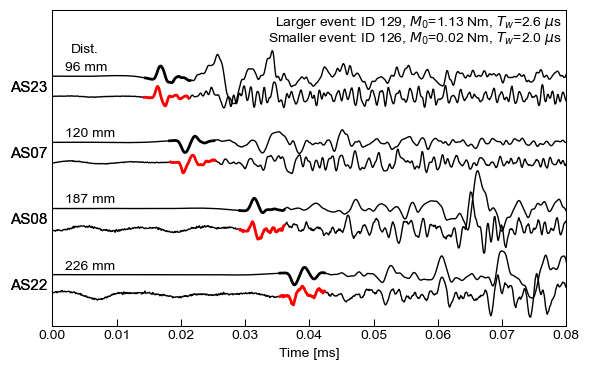

In [29]:
fig, ax =  plt.subplots(1, 1, figsize=(6, 3.8))

ycenter = 0
ampnorm_normalized = 5

ytickloc = []
yticklabel = []

for stnm in AEsensor_list:

    for i, datacase in enumerate(waveform_pairs):

        gougeevent_id = int(datacase.split("__")[1])
        
        tr_obs_filtered = st_all.select(station=stnm, location=f"{datacase}_filtered")[0]
        tr_obs_filtered_trimmed = st_all.select(station=stnm, location=f"{datacase}_filtered_P")[0]

        tvec = tr_obs_filtered.times()*1e3
        tvec_trimmed = tr_obs_filtered_trimmed.times()
        trim_st = tr_obs_filtered_trimmed.stats.trim_st

        pretrigger = tr_obs_filtered.stats.pretrigger
        
        ampnorm_peak_P = np.max(np.abs(tr_obs_filtered_trimmed.data))
        plotamp = abs(ampnorm_peak_P) * ampnorm_normalized

    
        # align at arrival time
        onset_p_t = df_onset_merged[(df_onset_merged["datacase"]==datacase) & (df_onset_merged["sensor"]==stnm)]["onset_t[ms]"].values[0]
        tp = tr_obs_filtered.stats.dist / cp
        dtshift = tp - onset_p_t

        if i == 0:
            y_shift = +0.2 # plot up
            lc_P = "k"
        else:
            y_shift = -0.2 # plot bottom
            lc_P = "r"

        print(ycenter, y_shift)
        offset = np.mean(tr_obs_filtered.data[:int(0.01e-3*fs)]) # remove offset
        ax.plot(tvec - pretrigger + dtshift, (tr_obs_filtered.data-offset)/plotamp - ycenter + y_shift, "k-", lw=1.0)    
        ax.plot((tvec_trimmed + trim_st) * 1e3 - pretrigger + dtshift, (tr_obs_filtered_trimmed.data-offset)/plotamp - ycenter + y_shift, "-", c=lc_P, label="Raw", lw=2.0)
        
        ytickloc.append(-ycenter)
        yticklabel.append(f"AS{stnm[2:]}")

        if stnm==AEsensor_list[0]:
            # annotate event info
            M0 = df_selected.loc[gougeevent_id]["M0"]
            Tw = df_selected.loc[gougeevent_id]["Tw"] * 1e6
            # annotstr = fr"Event ID {gougeevent_id}: $M_0$={M0:.2f} Nm, $T_w$={Tw:.1f} $\mu$s"
            # annotstr = "\n".join([fr"Event ID {gougeevent_id}:", fr"$M_0$={M0:.2f} Nm, $T_w$={Tw:.1f} $\mu$s"])
            annotstr = fr"ID {gougeevent_id}, $M_0$={M0:.2f} Nm, $T_w$={Tw:.1f} $\mu$s"
            fontsize = 10
            if i == 0:
                ax.text(0.99, 0.95, "Larger event: " + annotstr, transform=ax.transAxes, fontsize=fontsize, ha="right")
            else:
                ax.text(0.99, 0.9, "Smaller event: " + annotstr, transform=ax.transAxes, fontsize=fontsize, ha="right")

        print(tr_obs_filtered.stats.dist)
        if i == 0:
            # annotate distance
            ax.text(2e-3, -ycenter+y_shift+0.1, f"{dist_ave[stnm]:.0f} mm")
        
    ycenter += 1.3

ax.text(0.005, 0.65, "Dist.", ha="center")

ax.set_xlim([0, 0.08])
    
ax.set_ylim([ytickloc[-1] - 0.8, ytickloc[0] + 1.5])
ax.set_xlabel("Time [ms]")
ax.set_yticks(np.round(ytickloc, 3))
ax.set_yticklabels(yticklabel, fontsize=11)
ax.yaxis.set_tick_params(size=0)   # Hide tick marks but keep grid lines

fig.align_ylabels()

fig.tight_layout()

plt.savefig(figdir + f"/FigS_waveformpair_{waveform_pairs}.png", dpi=70, bbox_inches='tight')
plt.savefig(figdir + f"/FigS_waveformpair_{waveform_pairs}.eps", bbox_inches='tight')


## Plot amplitude spectra

In [30]:
# reference: https://stackoverflow.com/a/46685019

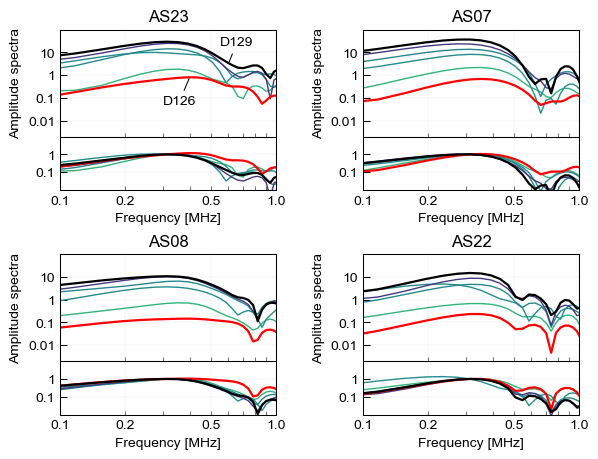

In [31]:
fig = plt.figure(figsize=(6.7, 5.))
outer_grid = mpl.gridspec.GridSpec(2, 2, wspace=0.4, hspace=0.4)


xlimit=[0.1, 1]

normalize_freq = 0.3e6 # normalize amplitude at this frequency
normalize_offset = 1e-3

for i in range(4):  # Loop over the 4 main subplots

    stnm = AEsensor_list[i]

    row, col = divmod(i, 2)
    
    # Define a 2×1 grid inside each outer subplot (2 rows, 1 column)
    inner_grid = mpl.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_grid[i], hspace=0.0, height_ratios=[2., 1])
    
    # Plot amplitude spectra
    for j in range(2):
        ax = plt.Subplot(fig, inner_grid[j])

        ax.set_xscale('log') # set logscale
        ax.set_yscale('log')
        
        for k, datacase in enumerate(event_all):
            
            key_Fabs = f"Fabs_{datacase}_{stnm}"
            key_freq = f"Ffreq_{datacase}_{stnm}"
            
            Xabs = Freqdata_all[key_Fabs] 
            freq = Freqdata_all[key_freq]

            # normalizing factor
            freq_norm = np.where(freq>normalize_freq)[0][0]
            Xabs_norm = Xabs[freq_norm]
            
            if datacase == largest_event_datacase:
                lc = "k"
                lw = 1.6
                zo = 3
            elif datacase == smallest_event_datacase:
                lc = "r"
                lw = 1.6
                zo = 2 
            else:
                lc = lc_dict[datacase] #"gray"
                lw = 1
                zo = 1

            if j==0:
                ax.plot(freq/1e6, Xabs, c=lc, lw=lw, zorder = zo,)# marker=".", ms=3)
                ax.set_title(f"AS{stnm[2:]}")
                ax.set_ylim([2e-3, 1e2])
                ax.tick_params(labelbottom=False)    
                ax.set_ylabel("Amplitude spectra")
                ax.set_yticks([1e-2, 1e-1, 1e0, 1e1])
                
            else:       
                # plot normalized spectra
                ax.plot(freq/1e6, Xabs/Xabs_norm, zorder = zo, c=lc, lw=lw, ls="-",)# marker=".", ms=3)
                ax.set_ylim([1e-2, 1e1])
                ax.set_xlabel("Frequency [MHz]")
                ax.set_yticks([1e-1, 1e0])
                # ax.set_ylabel("Normalized\namplitude spectra")

            ax.set_xlim(xlimit)
            ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="major", zorder=0)
            ax.set_axisbelow(True)
        
            ax.set_xticks([0.1, 0.2, 0.5, 1.0])
            ax.set_xticklabels([0.1, 0.2, 0.5, 1.0])
            ax.tick_params(axis='x', which='major', size=3, width=0.4)

            ax.xaxis.set_minor_formatter(mticker.NullFormatter())  # Remove minor tick labels
            ax.yaxis.set_minor_locator(mticker.NullLocator())  # Remove minor tick labels

            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2g'))


            # # Align y-axis tick labels to the right
            # for label in ax.get_yaxis().get_majorticklabels():
            #     label.set_horizontalalignment('left')  # Align tick labels to the right
            #     label.set_verticalalignment('center')    # Align vertically in the center
            #     # Adjust the x-position for padding space
            #     padding = 0.0225  # Define the padding space
            #     label.set_x(label.get_position()[0] - padding)  # Add padding

        # annotate event ID
        if (i==0) & (j==0) :
            annot_xy = [(0.6, 3), (0.4, 0.9)]
            annot_xy_text = [(0.55, 20), (0.298, 0.05)]
            for ii, event_id in enumerate([largest_event_id, smallest_event_id]):
                ax.annotate(f"D{event_id:g}", xy=annot_xy[ii], xytext=annot_xy_text[ii],
                    arrowprops=dict(arrowstyle = '-', connectionstyle = 'arc3', lw=0.75), 
                    horizontalalignment="left", zorder=4, fontsize=10., c="k")
    

        fig.add_subplot(ax)  # Add subplot to figure

    
plt.savefig(figdir + f"/FigS_spectra.png", dpi=70, bbox_inches='tight')
plt.savefig(figdir + f"/FigS_spectra.eps", bbox_inches='tight')

  

## Plot spectral ratio

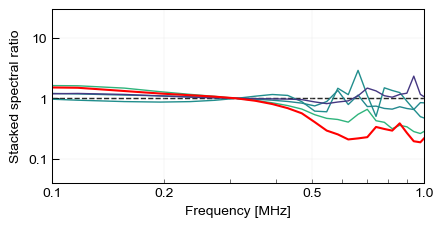

In [32]:
fig, ax =  plt.subplots(1, 1, figsize=(4.8, 2.25))

ax.set_xscale('log') # set logscale
ax.set_yscale('log')

for datacase in event_all:
    
    key_freq = f"Ffreq_{datacase}"
    key_specratiostacked = f"Fstacked_{datacase}"
    key_specratiostacke_std = f"Fstacked_std_{datacase}"

    freq = spectralratio_stacked[key_freq]
    specratio_stacked = spectralratio_stacked[key_specratiostacked]
    specratio_stacked_std = spectralratio_stacked[key_specratiostacke_std]

    # normalizing factor
    freq_norm = np.where(freq>normalize_freq)[0][0]
    specratio_norm = specratio_stacked[freq_norm]

    yerr=None
    if datacase == largest_event_datacase:
        lc = "None"
        lw = 1.5
        zo = 3
    elif datacase == smallest_event_datacase:
        lc = "r"
        lw = 1.5
        zo = 2 
        yerr = None # specratio_stacked_std/specratio_norm # Debug to plot std of stack
    else:
        lc =  lc_dict[datacase] #"k" #"gray"
        lw = 1.0
        zo = 1
                
    ax.errorbar(freq/1e6, specratio_stacked/specratio_norm, yerr=yerr, c=lc, lw=lw, zorder=zo)


# plot horizontal line at unity
ax.axhline(1, c="k", lw=1, ls="--", zorder=-1)

ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Stacked spectral ratio")

ax.set_xlim(xlimit)
# ax.set_ylim([1e-1, 1e1])
ax.set_ylim([4e-2, 3e1])
ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="major", zorder=0)
ax.set_axisbelow(True)

ax.set_xticks([0.1, 0.2, 0.5, 1.0])
ax.set_xticklabels([0.1, 0.2, 0.5, 1.0])
ax.tick_params(axis='x', which='major', size=3, width=0.4)

ax.xaxis.set_minor_formatter(mticker.NullFormatter())  # Remove minor tick labels
ax.yaxis.set_minor_locator(mticker.NullLocator())
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2g'))

plt.savefig(figdir + f"/FigS_spectralratio.png", dpi=70, bbox_inches='tight')
plt.savefig(figdir + f"/FigS_spectralratio.eps", bbox_inches='tight')

# Fitting with the theoretical spectral ratio model

The spectral ratio can be estimated as follows (e.g., Got and Fréche, 1993; Lengliné and Got, 2011):

$$ \dfrac{X(f)}{Y(f)} = \dfrac{XY^*}{YY^*} \simeq \dfrac{\Omega_X}{\Omega_Y}, $$ 

where $X$ and $Y$ are the spectra of observed waveform and $\Omega$ is the source spectrum. The spectrum of the observed waveform is written as 

$$X = GI{\Omega_X},$$

where $G$ and $I$ are the Green's function and instrumental response, respectively.

$\Omega(f)$  purely real when it strictly follows the omega-square model. However, the data does not show the purely real function due to the measurement error and the descrepancy with the inherent assumption such that the Green's function is same between two events. We thus compute the amptitude of the spectral ratio

$$ \dfrac{|XY^*|}{|YY^*|} \simeq \dfrac{|\Omega_X|}{|\Omega_Y|} = \dfrac{\Omega_X}{\Omega_Y}. $$

We could model the source spectra as follows (e.g., Yoshimitsu et al., 2014):

$$\Omega_X(\omega) = \dfrac{M_0}{1+(\omega/\omega_c)^{n}},$$
where $n$ indicates a fall-off rate. Then, the spectral ratio can be written as:

$$\dfrac{\Omega_{X}}{\Omega_{Y}} = \dfrac{M_{0}^X}{M_{0}^Y} \left[ \dfrac{1 + (\omega/\omega_{cY})^{n}}{1 + (\omega/\omega_{cX})^{n}} \right].$$

We search four parameters, $M_{0}^X, M_{0}^Y, \omega_{cX}, \omega_{cY}$ with a fixed $n$ of 4.

<!-- Assuming the omega-square model, the spectral ratio can be fit as follows:

$$ \ln \dfrac{\Omega_{X}^1}{\Omega_{X}^0} = \ln \dfrac{M_{0}^1}{M_{0}^0} + \ln \left[ \dfrac{1 + (\omega/\omega_{c0})^{\gamma}}{1 + (\omega/\omega_{c1})^{\gamma}} \right]. $$ -->




In [33]:
def compute_specratio(f, M0X, M0Y, fcX, fcY, n=2):
    """
    M0X, fcX: magnitude and corner frequency of larger event
    M0Y, fcY: magnitude and corner frequency of smaller event
    """
    N = len(f)
    Omega_ratio = np.zeros(N)
    for i in range(N):
        omega = 2 * np.pi * f[i]
        omega_cX = 2 * np.pi * fcX
        omega_cY = 2 * np.pi * fcY

        # print(omega, omega_c1, omega_c0)
        Omega_ratio[i] = (M0X/M0Y) * ((1+(omega/omega_cY)**n)/(1+(omega/omega_cX)**n))

    return Omega_ratio

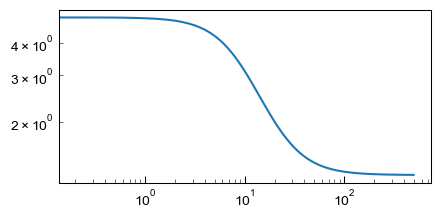

In [34]:
# test plot
fig, ax =  plt.subplots(1, 1, figsize=(4.8, 2.25))

M01 = 0.1
M00 = 0.02
fc1 = 10 #3e5
fc0 = 20 #5e5

freq_test = np.fft.rfftfreq(5001, d=0.001)
ax.loglog(freq_test, compute_specratio(freq_test, M01, M00, fc1, fc0))

## Fitting the spectral ratio

We minimize the residual between the observed and synthesized spectral ratio between `fit_fmin` and `fit_fmax`.

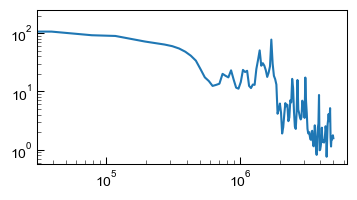

In [35]:
fit_fmin = 0.1e6
fit_fmax = 1.0e6

# observed spectral ratio

key_freq_small = f"Ffreq_{smallest_event_datacase}"
key_specratiostacked_small = f"Fstacked_{smallest_event_datacase}"

freq_small = spectralratio_stacked[key_freq_small]
specratio_stacked_small = spectralratio_stacked[key_specratiostacked_small]
fig, ax =  plt.subplots(1, 1, figsize=(4, 2))
ax.loglog(freq_small, specratio_stacked_small)

In [36]:
def compute_RMSE(params, f, specratio_obs, n=4):
    M0X, M0Y, fcX, fcY = params  # Model parameters
    specratio_model = compute_specratio(f, M0X, M0Y, fcX, fcY, n)
    rmse = np.sqrt(np.mean((specratio_obs - specratio_model) ** 2))  # Compute RMSE
    return rmse

fit_indices = (freq_small >= fit_fmin) & (freq_small <= fit_fmax)
f_fit = freq_small[fit_indices]
specratio_observation = specratio_stacked_small[fit_indices]

M0X_init, M0Y_init = df_events.loc[largest_event_id, :].M0, df_events.loc[smallest_event_id, :].M0  # Initial moment magnitudes
fcX_init, fcY_init = 1/(df_events.loc[largest_event_id, :].Tw), 1/( df_events.loc[smallest_event_id, :].Tw)  # Initial corner frequencies
initparam = [M0X_init, M0Y_init, fcX_init, fcY_init]
print(initparam)
bounds = [(1e-2, 1e1), (1e-2, 1e1), (1e5, 1e6), (1e5, 1e6)]

result = minimize(compute_RMSE, initparam, args=(f_fit, specratio_observation, 4), bounds=bounds, method='Nelder-Mead', tol=1e-8)

assert(result.success)
M0X_best, M0Y_best, fcX_best, fcY_best = result.x
print("Optimized Parameters:")
print(f"M0X = {M0X_best:.4f}, M0Y = {M0Y_best:.4f}, fcX = {fcX_best/1e6:.4f} MHz, fcY = {fcY_best/1e6:.4f} MHz")


[1.1312377, 0.017021253, 380757.578122888, 502119.244483266]
Optimized Parameters:
M0X = 1.1774, M0Y = 0.0143, fcX = 0.3705 MHz, fcY = 0.6057 MHz


## Plot spectral ratio with best_fit values

In [37]:
event_all

array(['fb03-087__0129', 'fb03-087__0126', 'fb03-087__0024',
       'fb03-087__0050', 'fb03-087__0052', 'fb03-087__0072'], dtype='<U14')

In [38]:
# event_all_debug = ['fb03-087__0126', 'fb03-087__0024', 'fb03-087__0050', 'fb03-087__0052']

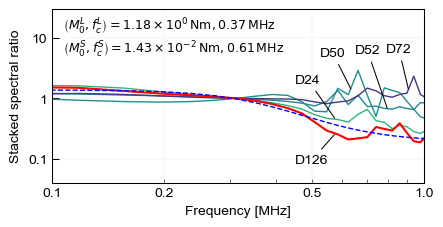

In [39]:
fig, ax =  plt.subplots(1, 1, figsize=(4.8, 2.25))

ax.set_xscale('log') # set logscale
ax.set_yscale('log')

for datacase in event_all:
# for datacase in event_all_debug:
    
    key_freq = f"Ffreq_{datacase}"
    key_specratiostacked = f"Fstacked_{datacase}"
    key_specratiostacke_std = f"Fstacked_std_{datacase}"

    freq = spectralratio_stacked[key_freq]
    specratio_stacked = spectralratio_stacked[key_specratiostacked]
    specratio_stacked_std = spectralratio_stacked[key_specratiostacke_std]

    # normalizing factor
    freq_norm = np.where(freq>normalize_freq)[0][0]
    specratio_norm = specratio_stacked[freq_norm]

    yerr=None
    if datacase == largest_event_datacase:
        lc = "None" # unity
        lw = 1.5
        zo = 3
    elif datacase == smallest_event_datacase:
        lc = "r"
        lw = 1.5
        zo = 2 
        yerr = None # specratio_stacked_std/specratio_norm # Debug to plot std of stack
    else:
        lc =  lc_dict[datacase] #"k" #"gray"
        lw = 1.0
        zo = 1
                
    ax.errorbar(freq/1e6, specratio_stacked/specratio_norm, yerr=yerr, c=lc, lw=lw, zorder=zo)


#---Plot example fitting curve---#
key_freq_small = f"Ffreq_{smallest_event_datacase}"
key_specratiostacked_small = f"Fstacked_{smallest_event_datacase}"

freq_small = spectralratio_stacked[key_freq_small]
specratio_stacked_small = spectralratio_stacked[key_specratiostacked_small]

# normalizing factor
freq_norm = np.where(freq_small>normalize_freq)[0][0]
specratio_norm_small = specratio_stacked_small[freq_norm]

ax.loglog(freq/1e6, compute_specratio(freq, M0X_best, M0Y_best, fcX_best, fcY_best, n=4)/specratio_norm_small,
          "--", label="Fit", zorder=4,  c="b", lw=1) #c=mpl.cm.viridis_r(c_norm(i+1)), alpha=0.2)

#-------------------------------#

#--- annotate the labels ----#
# fitting result
def format_scientific(value):
    exponent = int(np.floor(np.log10(abs(value))))
    coefficient = value / (10**exponent)
    return fr"{coefficient:.2f} \times 10^{{{exponent}}}"

annot_txt_l = fr"$\left( M_0^{{L}}, f_c^{{L}}\right) = {format_scientific(M0X_best)} \,\mathrm{{Nm}}, {fcX_best/1e6:.2f} \,\mathrm{{MHz}}$"
annot_txt_s = fr"$\left( M_0^{{S}}, f_c^{{S}}\right) = {format_scientific(M0Y_best)} \,\mathrm{{Nm}}, {fcY_best/1e6:.2f} \,\mathrm{{MHz}}$"
ax.text(0.03, 0.75, "\n".join([annot_txt_l, annot_txt_s]), transform=ax.transAxes, fontsize=9)

# annotate GP events
annot_ids = [126, 24, 50, 52, 72] #[126, 24, 50, 52, 72]
annot_xy = [(0.58, 0.27), (0.58, 0.43), (0.64, 1.3), (0.8, 0.62), (0.91, 1.3)]
annot_xy_text = [(0.45, 0.085), (0.45, 1.8), (0.525, 5.0), (0.65, 5.5), (0.79, 5.8)]

for ii, event_id in enumerate(annot_ids):

    ax.annotate(f"D{event_id:g}", xy=annot_xy[ii], xytext=annot_xy_text[ii],
        arrowprops=dict(arrowstyle = '-', connectionstyle = 'arc3', lw=0.75), 
        horizontalalignment="left", zorder=4, fontsize=10., c="k")
#-------------------------------#

# plot horizontal line at unity
# ax.axhline(1, c="k", lw=1, ls="-.", zorder=-1)

ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Stacked spectral ratio")

ax.set_xlim(xlimit)
# ax.set_ylim([1e-1, 1e1])
ax.set_ylim([4e-2, 3e1])
ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="major", zorder=0)
ax.set_axisbelow(True)

ax.set_xticks([0.1, 0.2, 0.5, 1.0])
ax.set_xticklabels([0.1, 0.2, 0.5, 1.0])
ax.tick_params(axis='x', which='major', size=3, width=0.4)

ax.xaxis.set_minor_formatter(mticker.NullFormatter())  # Remove minor tick labels
ax.yaxis.set_minor_locator(mticker.NullLocator())
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2g'))

plt.savefig(figdir + f"/FigS_spectralratio_womegasquarefit.png", dpi=70, bbox_inches='tight')
plt.savefig(figdir + f"/FigS_spectralratio_womegasquarefit.eps", bbox_inches='tight')

# Conclusion

This notebook conducted a spectral ratio analysis on gouge patch (GP) events to investigate spectral differences, suggesting the potential measurement limitations inferred from the smallest GP event. We could fit the spectral ratio with the theoretical estimate with reasnable pair of corner-frequency.